In [8]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
import tqdm
import matplotlib.pyplot as plt
import util.model
from sklearn.metrics import accuracy_score
from scipy.stats import chisquare

class attn_cls(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden, dropout):
        super().__init__()
        self.attn    = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=0)
        self.dropout = nn.Dropout(dropout)
        self.fc1     = nn.Linear(embed_dim, hidden)
        self.fc2     = nn.Linear(hidden, embed_dim)
        self.act     = nn.GELU()
    def forward(self, x, x_cls, src_key_padding_mask=None):
        x_cls = self.attn(x_cls, x, x, key_padding_mask=src_key_padding_mask)[0]
        x_cls = self.act(self.fc1(x_cls))
        x_cls = self.dropout(x_cls)
        x_cls = self.act(self.fc2(x_cls))
        return x_cls

class Classifier(nn.Module):
    def __init__(self, n_dim, embed_dim, hidden_dim, n_layers, n_layers_cls, n_heads, dropout):
        
        super().__init__()
        self.embed   = nn.Linear(n_dim, embed_dim)
        self.embed_e = nn.Sequential(util.model.GaussianFourierProjection(embed_dim=64), nn.Linear(64, 64))
        self.dense1  = util.model.Dense(64,1)
        self.encoder = nn.ModuleList(
            [
                util.model.Block(
                    embed_dim = embed_dim,
                    num_heads = n_heads,
                    hidden    = hidden_dim,
                    dropout   = dropout
                )
                for i in range(n_layers)
            ]
        )
        
        self.encoder_cls = nn.ModuleList(
            [
                attn_cls(
                    embed_dim = embed_dim,
                    num_heads = n_heads,
                    hidden    = hidden_dim,
                    dropout   = dropout
                )
            ]
        )
        
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embed_dim, 1)
        self.cls_token  = nn.Parameter(torch.ones(1, 1, embed_dim), requires_grad=True)
        self.cls_token2 = nn.Parameter(torch.ones(1, 1, embed_dim), requires_grad=True)
        self.act = nn.GELU()
        
    def forward(self, x, e, mask=None):
        
        x = self.embed(x)
        
        embed_e_ = self.act(self.embed_e(e))
        x += self.dense1(embed_e_).clone()
        
        x_cls = self.cls_token.expand(x.size(0),1,-1)
        
        for layer in self.encoder:
            x = layer(x, x_cls=x_cls, src_key_padding_mask = mask)
            
        x_cls2 = self.cls_token2.expand(x.size(0),1,-1)
        
        for layer in self.encoder_cls:
            x_cls2 = layer(x, x_cls=x_cls2, src_key_padding_mask = mask)
            
        return torch.flatten(self.out(x_cls2))
        
class evaluate_dataset(Dataset):
    
  def __init__(self, data, inE, label, device = 'cpu'):

    self.data  = data
    self.inE   = torch.tensor(inE, device=device)
    self.label = label
    self.max_nhits = -1

  def __getitem__(self, index):
    x = self.data[index]
    y = self.inE[index]
    z = self.label[index]
    return (x,y,z)
    
  def __len__(self):
    return len(self.data)
  
  def padding(self, value = -20):

    for showers in self.data:
        if len(showers) > self.max_nhits:
            self.max_nhits = len(showers)

    padded_showers = []
    for showers in self.data:
        pad_hits = self.max_nhits-len(showers)
        padded_shower = F.pad(input = showers, pad=(0,0,0,pad_hits), mode='constant', value = value)
        padded_showers.append(padded_shower)

    self.data = padded_showers
    self.padding_value = value

  def concat(self, dataset2):
    
    self.data.extend(dataset2.data)
    self.inE   = torch.concat((self.inE, dataset2.inE))
    self.label = torch.concat((self.label, dataset2.label))
    

class evaluator:

  def __init__(self, base_dataset_name, gen_dataset_name, padding_value = -20, device='cpu'):
  
    base_dataset = torch.load(base_dataset_name, map_location = torch.device(device))
    gen_dataset  = torch.load(gen_dataset_name,  map_location = torch.device(device))
    dataset_size = min(len(base_dataset[0]),len(gen_dataset[0]))
    base_data    = base_dataset[0][:dataset_size]
    gen_data     = gen_dataset[0][:dataset_size]
    base_inE     = base_dataset[1][:dataset_size]
    gen_inE      = gen_dataset[1][:dataset_size]
    base_label   = torch.ones(dataset_size, device=device)
    gen_label    = torch.zeros(dataset_size, device=device)
    
    self.padding_value = padding_value
    self.dataset = evaluate_dataset(base_data, base_inE, base_label, device)
    self.dataset.concat(evaluate_dataset(gen_data,  gen_inE,  gen_label,  device))
    self.dataset.padding(self.padding_value)
    self.train_dataset = None
    self.test_dataset  = None
    self.validation_dataset = None
    self.model = None
    self.device=device

  def separate_ttv(self, train_ratio, test_ratio):
    assert (train_ratio + test_ratio) < 1.0
    total_size = len(self.dataset)
    train_size = int(total_size * train_ratio)
    test_size  = int(total_size * test_ratio)
    valid_size = int(total_size - train_size - test_size)
    self.train_dataset, self.test_dataset, self.validation_dataset = torch.utils.data.random_split(self.dataset, [train_size, test_size, valid_size])

  def train(self, 
            model=None,
            batch_size=150,
            lr = 1e-4,
            jupyternotebook = False,
            mask = True,
            n_epochs = 50,
            indices = [0,1,2,3],
            device = 'cpu'):
    
    indices = torch.tensor(indices,device=device)
        
    shower_loader_train = DataLoader(self.train_dataset, batch_size = batch_size, shuffle=True)
    shower_loader_test  = DataLoader(self.test_dataset,  batch_size = batch_size, shuffle=True)
    
    model.to(device)
    optimiser = Adam(model.parameters(), lr=lr)
    
    av_training_acc_per_epoch = []
    av_testing_acc_per_epoch  = []
    
    fig, ax = plt.subplots(ncols=1, figsize=(4,4))

    if jupyternotebook:
        epochs = tqdm.notebook.trange(n_epochs)
        from IPython import display
        dh = display.display(fig, display_id=True)
    else:
        epochs = range(0, n_epochs)
                           
    for epoch in epochs:
                           
        cumulative_epoch_loss = 0.
        cumulative_test_epoch_loss = 0.
                
        for i, (shower_data, incident_energies, label) in enumerate(shower_loader_train, 0):
            masking = shower_data[:,:,3] == self.padding_value if mask else None
            shower_data = torch.index_select(shower_data,2,indices)
            output_vector = model(shower_data, incident_energies, mask = masking)
            criterion = torch.nn.BCEWithLogitsLoss()
            loss = criterion(output_vector, torch.flatten(label))
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            pred   = torch.round(torch.sigmoid(output_vector.detach()))
            target = torch.round(torch.flatten(label).detach())
            if i == 0:
                res_true = target
                res_pred = pred
            else:
                res_true = torch.cat((res_true, target), 0)
                res_pred = torch.cat((res_pred, pred),  0)
        
        for i, (shower_data, incident_energies, label) in enumerate(shower_loader_test,0):
            with torch.no_grad():
                masking = shower_data[:,:,3] == self.padding_value if mask else None
                shower_data = torch.index_select(shower_data, 2, indices)
                output_vector = model(shower_data, incident_energies, mask=masking)
                pred   = torch.round(torch.sigmoid(output_vector.detach()))
                target = torch.round(torch.flatten(label).detach())
                if i == 0:
                    res_true_test = target
                    res_pred_test = pred
                else:
                    res_true_test = torch.cat((res_true_test, target), 0)
                    res_pred_test = torch.cat((res_pred_test, pred),  0)
                    
        acc_train = accuracy_score(res_true.cpu(), res_pred.cpu())
        acc_test  = accuracy_score(res_true_test.cpu(), res_pred_test.cpu())
        av_training_acc_per_epoch.append(acc_train)
        av_testing_acc_per_epoch.append(acc_test)
        
        if jupyternotebook:
            epochs.set_description('Accuracy: {:2f}(Train) {:2f}(Test)'.format(acc_train,acc_test))

            fig, ax = plt.subplots(ncols=1, figsize=(4,4))
            plt.title('')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.yscale('log')
            plt.plot(av_training_acc_per_epoch, label='training')
            plt.plot(av_testing_acc_per_epoch, label='testing')
            plt.legend(loc='lower right')
            dh.update(fig)
            plt.close(fig)
    self.model = model
    return model
  def evulate_score(self, 
                    model=None, 
                    indices = [0,1,2,3],
                    batch_size = 150,
                    mask = True):
    if model is None:
        model = self.model
    indices = torch.tensor(indices,device=self.device)    
    shower_loader_validation = DataLoader(self.validation_dataset, batch_size = batch_size, shuffle=True)
    for i, (shower_data, incident_energies, label) in enumerate(shower_loader_validation,0):
        with torch.no_grad():
            masking = shower_data[:,:,3] == self.padding_value if mask else None
            shower_data = torch.index_select(shower_data, 2, indices)
            output_vector = model(shower_data, incident_energies, mask=masking)
            pred   = torch.round(torch.sigmoid(output_vector.detach()))
            target = torch.round(torch.flatten(label).detach())
            if i == 0:
                res_true_valid = target
                res_pred_valid = pred
            else:
                res_true_valid = torch.cat((res_true_valid, target), 0)
                res_pred_valid = torch.cat((res_pred_valid, pred),  0)
                    
    return (accuracy_score(res_true_valid.cpu(), res_pred_valid.cpu()))
            
  def draw_distribution(self):
    
    e_geant4 = []
    e_gen    = []
    x_geant4 = []
    x_gen    = []
    y_geant4 = []
    y_gen    = []
    z_geant4 = []
    z_gen    = []
    
    nEntries_geant4 = []
    nEntries_gen    = []
    
    point_clouds_loader = DataLoader(self.dataset, batch_size = 150)    
    for i, (shower_data, incident_energies, label) in enumerate(point_clouds_loader, 0):
    
        valid_event = []
        data_np = shower_data.cpu().numpy().copy()
        label_np = label.cpu().numpy().copy()
        
        mask = ~(data_np[:,:,3] == self.padding_value)
        
        for j in range(len(data_np)):
            valid_event = data_np[j][mask[j]]
            if label_np[j] == 0:
                e_gen += ((valid_event).copy()[:,0]).flatten().tolist()
                x_gen += ((valid_event).copy()[:,1]).flatten().tolist()
                y_gen += ((valid_event).copy()[:,2]).flatten().tolist()
                z_gen += ((valid_event).copy()[:,3]).flatten().tolist()
                nEntries_gen.append(len(valid_event))
            else:
                e_geant4 += ((valid_event).copy()[:,0]).flatten().tolist()
                x_geant4 += ((valid_event).copy()[:,1]).flatten().tolist()
                y_geant4 += ((valid_event).copy()[:,2]).flatten().tolist()
                z_geant4 += ((valid_event).copy()[:,3]).flatten().tolist()
                nEntries_geant4.append(len(valid_event))
                
    fig, ax = plt.subplots(2,3, figsize=(15,10))
    self.get_plot(ax[0][0], "# entries", "Hit entries", nEntries_geant4, nEntries_gen, np.arange(min(nEntries_geant4),max(nEntries_geant4),1))
    self.get_plot(ax[0][1], "# entries", "Hit energies", e_geant4, e_gen, np.arange(min(e_geant4),max(e_geant4),(max(e_geant4)-min(e_geant4))/100.))
    self.get_plot(ax[0][2], "# entries", "x", x_geant4, x_gen, np.arange(min(x_geant4),max(x_geant4),1))
    self.get_plot(ax[1][0], "# entries", "y", y_geant4, y_gen, np.arange(min(y_geant4),max(y_geant4),1))
    self.get_plot(ax[1][1], "# entries", "z", z_geant4, z_gen, np.arange(min(z_geant4),max(z_geant4),1))

    
  def get_plot(self, ax, y_label, x_label, x_geant4, x_gen, bins):
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    x_geant4_binned,_ = np.histogram(x_geant4, bins=bins)
    x_gen_binned,_    = np.histogram(x_gen,    bins=bins)
    #chi2 = ((x_geant4_binned - x_gen_binned)**2/(x_geant4_binned)).sum()/len(x_gen_binned)
    ax.hist(x_gen, bins = bins, label="gen", alpha=0.5)
    ax.hist(x_geant4, bins = bins, label="geant4", alpha=0.5)
    ax.legend(loc='upper right')
    
    
        
        

In [11]:
device = 'cuda'
evaluator1 = evaluator(base_dataset_name = "samples/toy_model.pt",
                       gen_dataset_name   = "sampling/embed64_hid128_6trans_4head_dropout0_mask/sample.pt",
                       device = device)

/tmp/ipykernel_492/3102205069.py:88: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



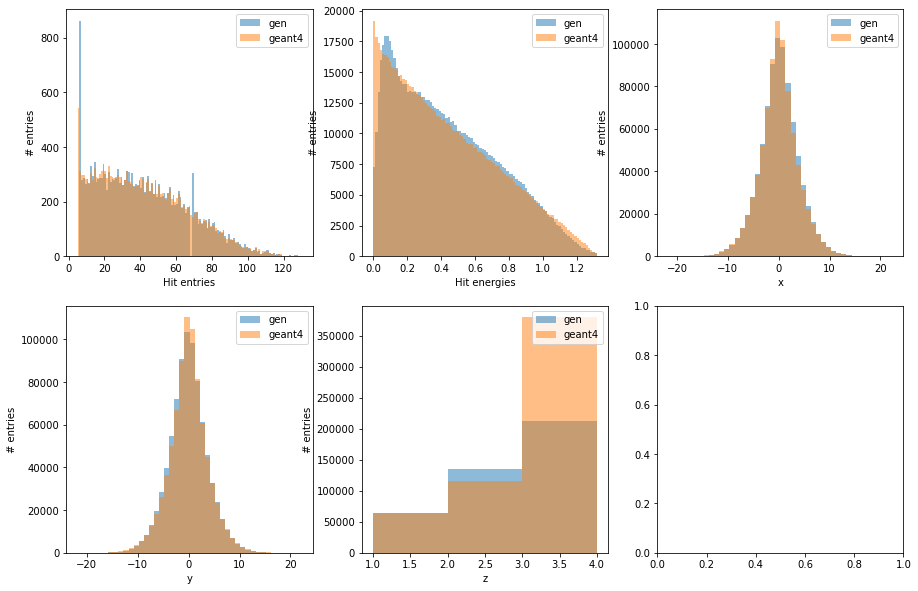

In [12]:
evaluator1.draw_distribution()

Initial GaussianFourierProjection W weights: Parameter containing:
tensor([ 12.2698,  24.1013, -21.6735,  -6.2883,  54.8418,  15.1697,  64.3002,
          3.1778, -56.5770,  42.7590, -29.5885, -54.5300,   6.1150, -36.2156,
         17.9030, -35.2141, -18.2538,  -6.4025,  -2.6773,  -5.5340,  12.3054,
         42.2616, -39.5594,  15.9805,  -9.7913, -38.0174, -62.8607, -33.1240,
        -40.9493,  31.4319,  42.6401,  38.6056])
Initial Dense weights: Parameter containing:
tensor([[ 0.0361,  0.0087,  0.0555, -0.1014, -0.0267, -0.0558,  0.0934,  0.1222,
         -0.1123,  0.0084,  0.1095,  0.1100,  0.0497, -0.0187,  0.0345,  0.0715,
          0.0232,  0.0582,  0.1214, -0.0726, -0.1040, -0.0708, -0.0417,  0.0795,
         -0.0792,  0.0110, -0.0827,  0.0402,  0.0684, -0.0041,  0.0168, -0.0470,
          0.0429,  0.0755,  0.1021, -0.0984,  0.0567,  0.0262,  0.1145, -0.0438,
          0.0197,  0.0369, -0.0980,  0.1114,  0.0621, -0.0093, -0.0740,  0.0718,
         -0.0646,  0.1111, -0.0183, -0.03

  0%|          | 0/20 [00:00<?, ?it/s]

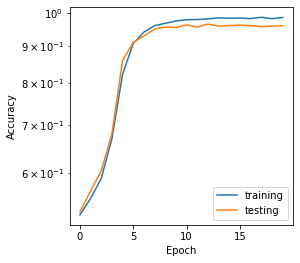

score 0.96575


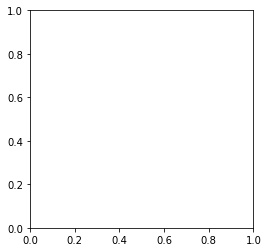

In [16]:
indices = [1] # 0: e, 1: x, 2: y, 3:z (choose parameters set used for training)
model = Classifier(n_dim=len(indices),
                   embed_dim=64,
                   hidden_dim=64,
                   n_layers=2,
                   n_layers_cls=2,
                   n_heads=2,
                   dropout=0)

evaluator1.separate_ttv(0.8,0.1)
evaluator1.train( 
            model=model,
            jupyternotebook = True,
            mask = True,
            n_epochs = 20,
            device = device,
            indices = indices)
print('score', evaluator1.evulate_score(
                    model   = model, 
                    indices = indices))